# Forward modeling

We often want to try to predict what the earth will look like in seismic. This can help us interpret seismic, or just hone our intuition about tuning or interference.

In this notebook, we look at several ways to forward model seismic data, starting with a very simple 1D model, then moving to real well logs, then to 2D models. 

In the course of the notebook, we'll see the following important digital concepts:

- Modeling a physical problem in code is a useful skill.
- Gradually solving a complex problem by iterating and plotting.
- How NumPy's n-dimensional arrays deal magically with multi-dimensional data.
- There's not much difference in our code between toy models and realistic models.
- How Jupyter can help us make interactive displays to help us learn.

----

## 1D synthetic

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

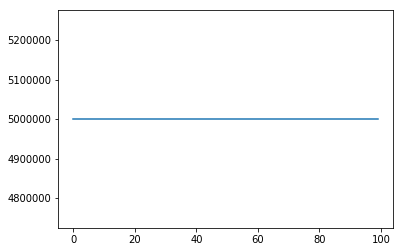

In [2]:
vp = np.ones(100) * 2000
rho = np.ones(100) * 2500

imp = vp * rho

plt.plot(imp)

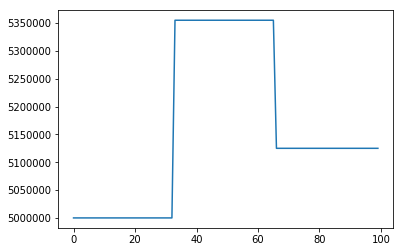

In [3]:
vp[33:66] = 2100
vp[66:] = 2050

rho[33:66] = 2550
rho[66:] = 2500

imp = vp * rho

plt.plot(imp)

<StemContainer object of 3 artists>

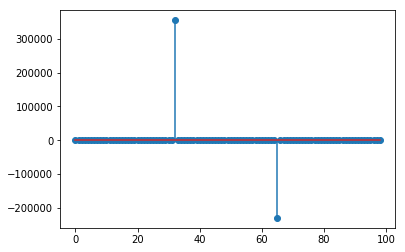

In [4]:
rc = np.diff(imp)

plt.stem(rc)

In [5]:
!pip install bruges

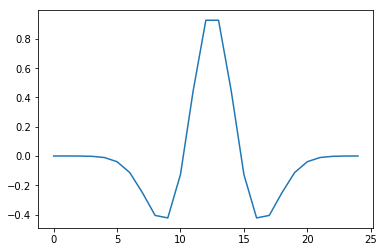

In [6]:
import bruges

w = bruges.filters.ricker(0.25, 0.01, 10)

plt.plot(w)

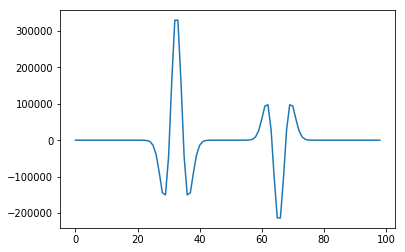

In [7]:
syn = np.convolve(rc, w, mode='same')

plt.plot(syn)

## Real data

In [8]:
!pip install welly

In [9]:
from welly import Well

w = Well.from_las('../data/R-39.las')

In [10]:
dtp = w.data['DT4P']
dts = w.data['DT4S']
rho = w.data['RHOB']
z = dtp.basis

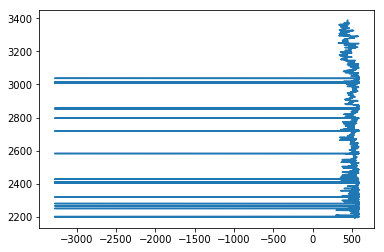

In [11]:
plt.plot(dts, z)

In [12]:
dts[dts < 0] = np.nan
dts = dts.interpolate()

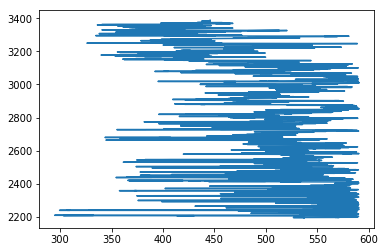

In [13]:
plt.plot(dts, z)

In [14]:
vp = 1e6 / dtp
vs = 1e6 / dts

rc = bruges.reflection.reflectivity(vp, vs, rho)

<StemContainer object of 3 artists>

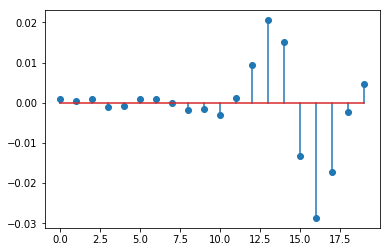

In [15]:
plt.stem(rc.real[:20])

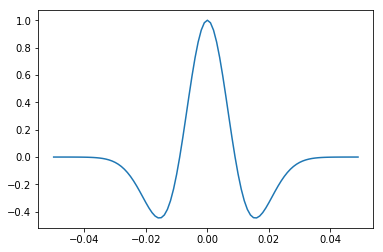

In [16]:
w, t = bruges.filters.ricker(0.1, 0.001, 25 ,return_t=True)

plt.plot(t, w)

/home/matt/anaconda3/envs/digdisc/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(2000, 2500)

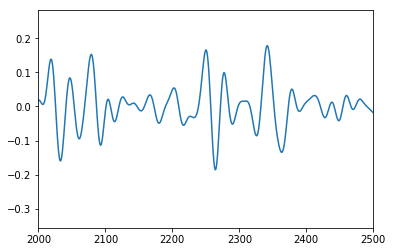

In [17]:
syn = np.convolve(rc, w)

plt.plot(syn)

plt.xlim(2000, 2500)

In [18]:
rc = bruges.reflection.reflectivity(vp, vs, rho, theta=range(45))

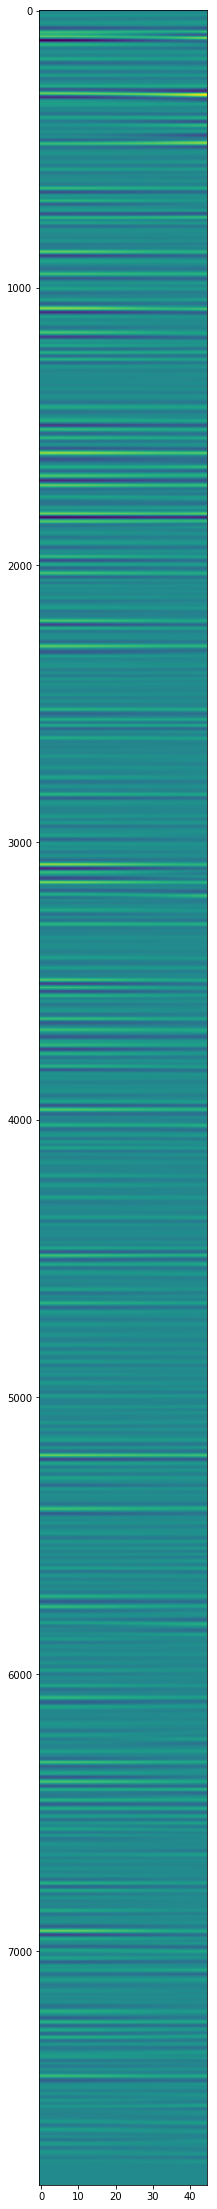

In [19]:
def make_syn(rc, w):
    func = lambda tr: np.convolve(tr, w, mode='same')
    syn = np.apply_along_axis(func, arr=rc, axis=-1)
    return syn.T

syn = make_syn(rc, w)

fig, ax = plt.subplots(figsize=(3, 40))
ax.imshow(syn.real, aspect='auto')

## A 2D model

In [20]:
import matplotlib.image as img

model = img.imread("../data/wedge.png")
model = model[..., 0]
model.shape

(283, 400)

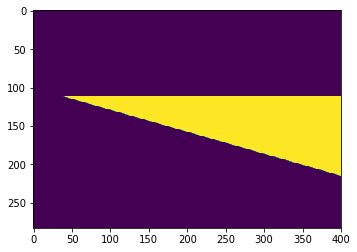

In [21]:
plt.imshow(model)

In [22]:
rc = bruges.reflection.acoustic_reflectivity(model, model)

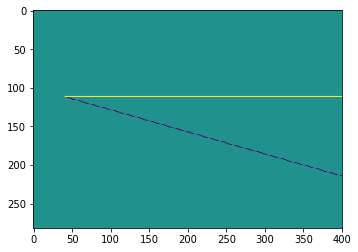

In [23]:
plt.imshow(rc)

In [24]:
syn = make_syn(rc.T, w)

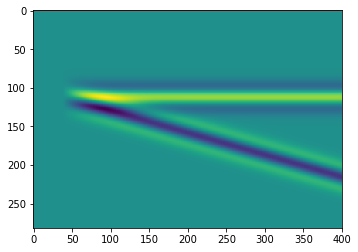

In [25]:
plt.imshow(syn)

## Construct a model

In [26]:
length = 80  # x range
depth = 200  # z range

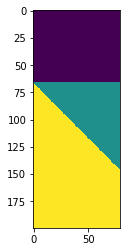

In [27]:
model = 1 + np.tri(depth, length, -depth//3, dtype=int)
model[:depth//3:,:] = 0

plt.imshow(model)

Now we can make some Vp-rho pairs (rock 0, rock 1, and rock 2).

In [28]:
rocks = np.array([[2700, 2750],
                  [2400, 2450],
                  [2800, 3000]])

Now we can use ['fancy indexing'](http://docs.scipy.org/doc/numpy/user/basics.indexing.html) to use `model`, which is an array of 0, 1, and 2, as the indices of the rock property pairs to 'grab' from `rocks`.

In [29]:
earth = rocks[model]

Now apply `np.product` to those Vp-rho pairs to get impedance at every sample.

In [30]:
earth.shape

(200, 80, 2)

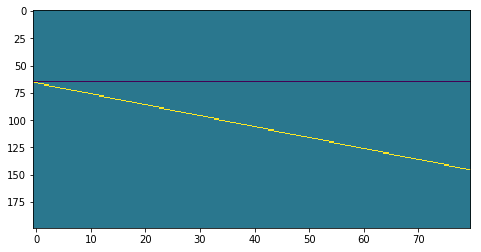

In [31]:
rc = bruges.reflection.acoustic_reflectivity(*np.rollaxis(earth, -1))

plt.figure(figsize=(8, 4))
plt.imshow(rc, aspect=0.2)

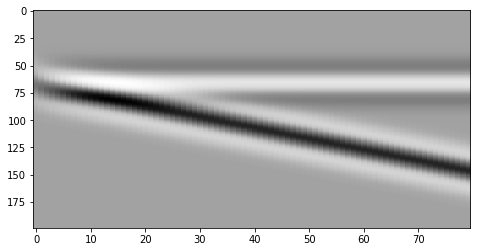

In [32]:
syn = make_syn(rc.T, w)

plt.figure(figsize=(8, 4))
plt.imshow(syn, cmap="Greys", aspect=0.2)

In [33]:
rms = np.sqrt(np.sum(rc**2)/rc.size)

In [34]:
rc += (np.random.random(rc.shape) - 0.5) * 1 * rms

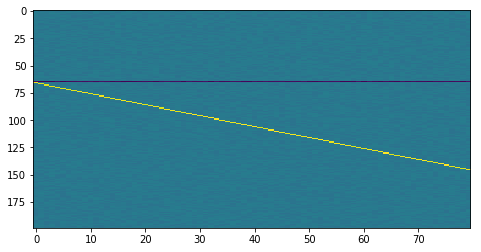

In [35]:
plt.figure(figsize=(8, 4))
plt.imshow(rc, aspect=0.2)

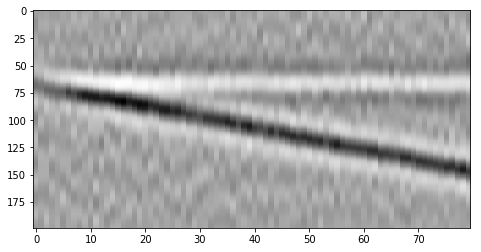

In [36]:
syn_noisy = make_syn(rc.T, w)

plt.figure(figsize=(8, 4))
plt.imshow(syn_noisy, cmap="Greys", aspect=0.2)

In [37]:
apparent = np.min(syn_noisy, axis=0)
t_apparent = np.argmin(syn, axis=0)

actual = syn_noisy[depth//3, :]
t_actual = np.ones_like(t_apparent) * depth//3

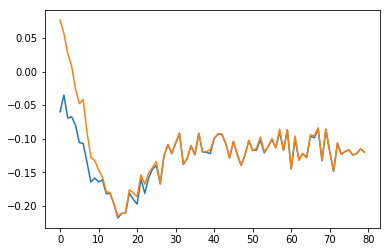

In [38]:
plt.plot(apparent)
plt.plot(actual)
plt.show()

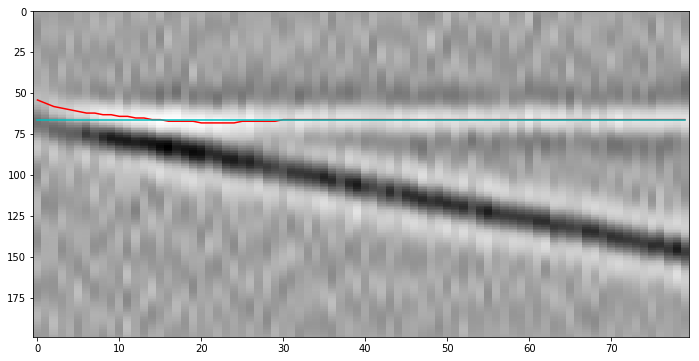

In [39]:
plt.figure(figsize=(12,6))

# Plot seismic
plt.imshow(syn_noisy, cmap="Greys", aspect=0.2)

# Plot horizons
plt.plot(t_apparent, 'r')
plt.plot(t_actual, 'c')

plt.show()

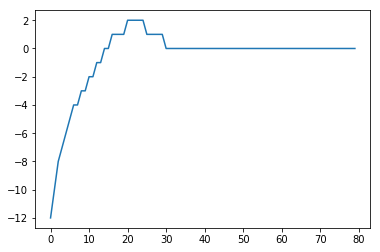

In [40]:
plt.plot(t_apparent - t_actual)

### Exercise

- Can you make a horizon for the bottom of the wedge?
- Does the frequency affect the amplitude of the horizons? 
- Try using some of the other wavelets in `bruges.filters`. Do they affect the horizons?

## A really cool model

Let's load an image and use it as a model.

In [41]:
model = img.imread('../data/hubbard_etal_2014.png')

This is just a 4-channel PNG (red, green, blue, alpha).

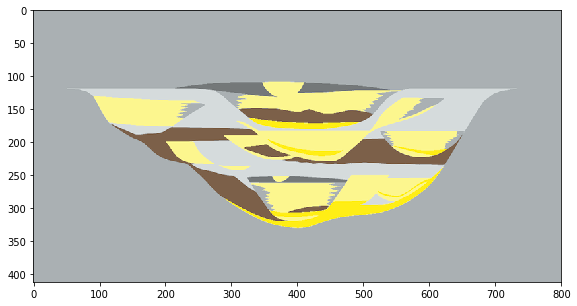

In [42]:
plt.figure(figsize=(10, 5))
plt.imshow(model)

Let's pretend we can make impedance by averaging the channels (there are lots of equally geologically silly ways to do this).

In [43]:
earth = model[..., :2]

In [44]:
rc = bruges.reflection.acoustic_reflectivity(*np.rollaxis(earth, -1))

In [45]:
syn = make_syn(rc.T, w)

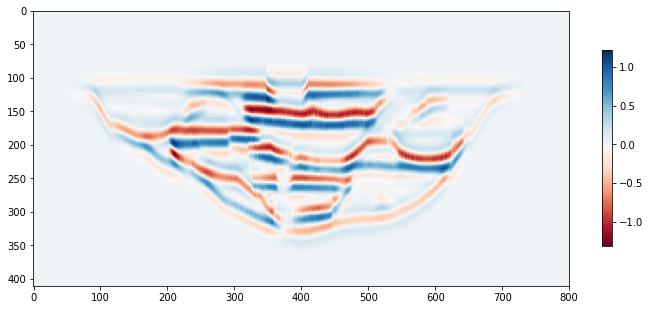

In [46]:
plt.figure(figsize=(12,12))
plt.imshow(syn, cmap="RdBu")
plt.colorbar(shrink=0.3)
plt.show()

In [47]:
from ipywidgets import interact

@interact(f=(5, 50, 2.5))
def make_plot(f):
    w = bruges.filters.ricker(0.1, 0.001, f)
    syn = make_syn(rc.T, w)
    plt.figure(figsize=(12,12))
    plt.imshow(syn, cmap="RdBu")
    plt.show()

interactive(children=(FloatSlider(value=25.0, description='f', max=50.0, min=5.0, step=2.5), Output()), _dom_c…

### Exercise

- Make a model of your own! Try this: http://sketch2model.com/app

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2018</p>
</div>